<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://cdn.miami.edu/_assets-common/images/system/um-logo-gray-bg.png" alt="Miami Logo" style="height: 98px;">
</div>

<h2>Rapid moistening of column water vapor: what's going on there?</h2>
<h3>Drilling down into the science of:</h3>

Mapes, B. E., Chung, E. S., Hannah, W. M., Masunaga, H., Wimmers, A. J., & Velden, C. S. (2018). The meandering margin of the meteorological moist tropics. Geophysical Research Letters, 45. https://doi.org/10.1002/2017GL07644. Free ReadCube viewing at http://rdcu.be/GpqN.

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

### Steps in the analysis 
1. <a href="#import">Importing CWV and AT data</a>
1. <a href="#joint">Joint distributions</a>
1. <a href="#buildclickmap">Build clickable maps in Holoviews</a>
1. <a href="#clickmap">Clickable maps of high AT scenes</a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime
from datetime import timedelta
from IPython.display import HTML,display

In [2]:
%matplotlib inline

<a name="import"></a>
---------
## Open the daily (v4) MIMIC-AT dataset
#### download from here for speed, or use the OpenDAP link in the code cell below
[MIMIC-AT Repository](http://weather.rsmas.miami.edu/repository/entry/show?entryid=0ce7321c-8278-47ef-bb56-7db18c21ea7d), or here [as a single datafile](http://weather.rsmas.miami.edu/repository/entry/show?entryid=synth%3A1142722f-a386-4c17-a4f6-0f685cd19ae3%3AL01JTUlDX2FnZ190ZW1wL01JTUlDLndpdGhfQVQudjQuMjAxNS0yMDE2LjJkZWdfbGF0dHJ1bmMubmM%3D)

In [3]:
###REMOTE DATASET: 2 years
da = xr.open_dataset('https://weather.rsmas.miami.edu/repository/opendap/synth:0ce7321c-8278-47ef-bb56-7db18c21ea7d:L01JTUlDX0FUX2RhaWx5LjIwMTUtMjAxNl8yZGVnLm5jbWw=/entry.das')

###REMOTE DATASET: 1 month
#da=xr.open_dataset('http://weather.rsmas.miami.edu/repository/opendap/synth:0ce7321c-8278-47ef-bb56-7db18c21ea7d:L01JTUlDLndpdGhfQVQudjQuMjAxNzAzLm5j/entry.das')

###Open local dataset if you downloaded it first
#da=xr.open_dataset('MIMIC.with_AT.v4.2015-2016.2deg_lattrunc.nc')

da

<xarray.Dataset>
Dimensions:    (lat: 90, lon: 180, time: 730)
Coordinates:
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 18.0 ...
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 -79.0 -77.0 -75.0 ...
  * time       (time) datetime64[ns] 2015-01-01T12:00:00 2015-01-02T12:00:00 ...
Data variables:
    TPW_TEND   (time, lat, lon) float64 ...
    mosaicTPW  (time, lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.6.4 (http://code.zmaw.de/p...
    Conventions:  CF-1.4
    history:      Thu Apr 12 20:02:33 2018: cdo remapcon,r180x90 MIMIC.with_A...
    CDO:          Climate Data Operators version 1.6.4 (http://code.zmaw.de/p...

<a name="joint"></a>
## General character of the data 
### Joint histogram of TPW and its Lagrangian tendency

(30, 70)

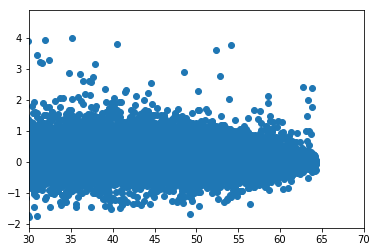

In [4]:
subset = da.sel(time=slice(datetime(2015,1,1),datetime(2015,1,30)))\
           .sel(lat =slice(-30,30))

x = subset.mosaicTPW.data
y = subset.TPW_TEND.data
plt.scatter(x,y); plt.xlim(30,70)

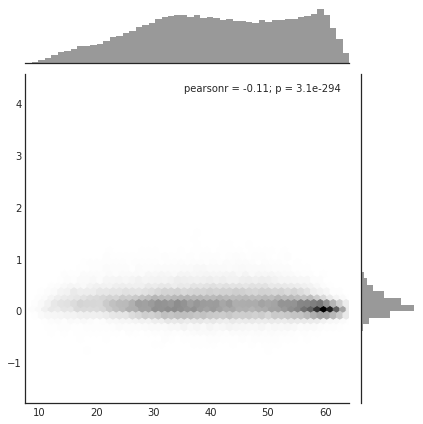

In [5]:
# To get marginals (see skew and bimodality), use Seaborn
import pandas as pd
import seaborn as sns
# sns.set(color_codes=True)

df = pd.DataFrame({'x': [x], 'y': [y] })
with sns.axes_style("white"): 
    sns.jointplot(x=x, y=y, kind="hex", color="k");

<a name="buildclickmap"></a>

--------------

# Utilities: make clickable map


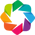

In [6]:
import holoviews as hv
from bokeh.models import OpenURL, TapTool, HoverTool

hv.notebook_extension('bokeh')

### make custom function for drawing coastlines

In [7]:
def coastlines(resolution='110m',lon_360=False):
    """ A custom method to plot in cylyndrical equi projection, most useful for
        native projections, geoviews currently supports only Web Mercator in
        bokeh mode.
        
        Other resolutions can be 50m
        
        lon_360 flag specifies if longitudes are from -180 to 180 (default) or 0 to 360
        TODO: if hv.Polygons is used instead of overlay it is way faster but 
              something is wrong there.
    """
    try:
        import cartopy.io.shapereader as shapereader
        from cartopy.io.shapereader import natural_earth
        import shapefile
        filename = natural_earth(resolution=resolution,category='physical',name='coastline')
    
        sf = shapefile.Reader(filename)
        fields = [x[0] for x in sf.fields][1:]
        records = sf.records()
        shps = [s.points for s in sf.shapes()]
        pls=[]
        for shp in shps:
            lons=[lo for lo,_ in shp]
            lats=[la for _,la in shp]
            if lon_360:
                lats_patch1=[lat for lon,lat in zip(lons,lats) if lon<0]
                lons_patch1=[lon+360.0 for lon in lons if lon<0]
                if any(lons_patch1):
                    pls.append(hv.Path((lons_patch1,lats_patch1))(style={'color':'Black'}))    
                lats_patch2=[lat if lon>=0 else None for lon,lat in zip(lons,lats)]
                lons_patch2=[lon if lon>=0 else None for lon in lons]
                if any(lons_patch2):
                    pls.append(hv.Path((lons_patch2,lats_patch2))(style={'color':'Black'}))
            else:
                pls.append(hv.Path((lons,lats))(style={'color':'Black'}))
        return hv.Overlay(pls)
    except Exception as err:
        print('Overlaying Coastlines not available from holoviews because: {0}'.format(err))

In [8]:
coastline=coastlines(lon_360=True) #this may download shape files on first invocation
                                   #if data longitudes are -180 to 180 then lon_360=False

### Create some tools to attach to the plots: hover tool for values

In [9]:
hover = HoverTool(
        tooltips=[
            ("Time", "@eventtimestr"),
            ("(Lat,Lon)", "(Lon=@eventlonstr{0[.]00}, Lat=@eventlatstr{0[.]00})"),
            ("TPW_TEND","@TPW_TEND"),
            ("TPW","@mosaicTPW")
        ]
    )
#gives info on hovering on a location in the plot

### Create some tools to attach to the plots: tap tool calls the NASA URL! 

In [10]:
tptool=TapTool()
base_url = 'https://worldview.earthdata.nasa.gov/?p=geographic&l=VIIRS_SNPP_CorrectedReflectance_TrueColor,MODIS_Aqua_CorrectedReflectance_TrueColor(hidden),MODIS_Terra_CorrectedReflectance_TrueColor(hidden),Graticule,AMSR2_Columnar_Water_Vapor_Night(opacity=0.48,palette=rainbow_2,min=45.857742,46.192467,max=49.874477,50.209206,squash),AMSR2_Columnar_Water_Vapor_Day(hidden,opacity=0.3,palette=rainbow_2,min=45.857742,46.192467,max=49.874477,50.209206,squash),Coastlines'
suffix = '&t=@eventdatestr&z=3&v=@eventlonstrW,@eventlatstrS,@eventlonstrE,@eventlatstrN&ab=off&as=@eventdatestr&ae=@eventdatestr1&av=3&al=true'
tptool.callback=OpenURL(url = base_url+suffix)
#on clicking at a point will take to the url specified

### Something about stacking so that big values can be prioritized

In [11]:
stacked=da.stack(timelatlon=['time','lat','lon']) #stack them so that sorting is easy

In [12]:
def threshold_TPW(threshold=50,max_points=100):
    """ Given a threshold of TPW this function return plot corresponding to locations of first 
        max_points values of TPW_TEND in an increasingly sorted array"""
    
    events=stacked.where(stacked['mosaicTPW']>threshold) #threshold based on TPW
    events=events.fillna(-999).sortby('TPW_TEND',ascending=False) # sorting doesnt know how to handle 
                                                      #NANs it might think they are maximums so fill -999 to make 
                                                     #them irrrelavent. if we were searching for mins then fill nans 
                                                     #as a high positive number
    ## add some metadata to data that will make url construction easy 
    df=events.to_dataframe().reset_index()[0:max_points]
    df['eventdatestr']=df.time.apply(lambda x:str(x).split()[0])
    df['eventdatestr1']=df.time.apply(lambda x:str(x+timedelta(days=1)).split()[0])
    df['eventlonstrE']=df.lon.apply(lambda x:str(x+10.0))
    df['eventlonstrW']=df.lon.apply(lambda x:str(x-10.0))
    df['eventlatstrN']=df.lat.apply(lambda x:str(x+7.5))
    df['eventlatstrS']=df.lat.apply(lambda x:str(x-7.5))
    df['eventtimestr']=df.time.apply(str)
    df['eventlonstr']=df.lon.apply(str)
    df['eventlatstr']=df.lat.apply(str)
    
    vdims=['TPW_TEND','mosaicTPW','eventtimestr','eventlatstr','eventlonstr',
       'eventdatestr','eventdatestr1','eventlonstrW','eventlonstrE','eventlatstrN','eventlatstrS']
    hvd=hv.Dataset(df,kdims=['lon','lat'])
    pts=hvd.to(hv.Points,kdims=['lon','lat'],vdims=vdims).opts(plot={'tools':[hover,tptool]})
    return pts*coastline

<a name="clickmap"></a>

--------------

# Clickable map to see high-AT cloud scenes from Worldview

In [13]:
%%opts Points  (cmap='viridis' size=0.5) [width=800 height=400 color_index='TPW_TEND' size_index='mosaicTPW' colorbar=True]
threshold_TPW(threshold=40,max_points=1000)

:Overlay
   .Points.I      :Points   [lon,lat]   (TPW_TEND,mosaicTPW,eventtimestr,eventlatstr,eventlonstr,eventdatestr,eventdatestr1,eventlonstrW,eventlonstrE,eventlatstrN,eventlatstrS)
   .Path.I        :Path   [x,y]
   .Path.II       :Path   [x,y]
   .Path.III      :Path   [x,y]
   .Path.IV       :Path   [x,y]
   .Path.V        :Path   [x,y]
   .Path.VI       :Path   [x,y]
   .Path.VII      :Path   [x,y]
   .Path.VIII     :Path   [x,y]
   .Path.IX       :Path   [x,y]
   .Path.X        :Path   [x,y]
   .Path.XI       :Path   [x,y]
   .Path.XII      :Path   [x,y]
   .Path.XIII     :Path   [x,y]
   .Path.XIV      :Path   [x,y]
   .Path.XV       :Path   [x,y]
   .Path.XVI      :Path   [x,y]
   .Path.XVII     :Path   [x,y]
   .Path.XVIII    :Path   [x,y]
   .Path.XIX      :Path   [x,y]
   .Path.XX       :Path   [x,y]
   .Path.XXI      :Path   [x,y]
   .Path.XXII     :Path   [x,y]
   .Path.XXIII    :Path   [x,y]
   .Path.XXIV     :Path   [x,y]
   .Path.XXV      :Path   [x,y]
   .Path.XXVI     :Path   [x,y]
   .Path.XXVII    :Path   [x,y]
   .Path.XXVIII   :Path   [x,y]
   .Path.XXIX     :Path   [x,y]
   .Path.XXX      :Path   [x,y]
   .Path.XXXI     :Path   [x,y]
   .Path.XXXII    :Path   [x,y]
   .Path.XXXIII   :Path   [x,y]
   .Path.XXXIV    :Path   [x,y]
   .Path.XXXV     :Path   [x,y]
   .Path.XXXVI    :Path   [x,y]
   .Path.XXXVII   :Path   [x,y]
   .Path.XXXVIII  :Path   [x,y]
   .Path.XXXIX    :Path   [x,y]
   .Path.XL       :Path   [x,y]
   .Path.XLI      :Path   [x,y]
   .Path.XLII     :Path   [x,y]
   .Path.XLIII    :Path   [x,y]
   .Path.XLIV     :Path   [x,y]
   .Path.XLV      :Path   [x,y]
   .Path.XLVI     :Path   [x,y]
   .Path.XLVII    :Path   [x,y]
   .Path.XLVIII   :Path   [x,y]
   .Path.XLIX     :Path   [x,y]
   .Path.L        :Path   [x,y]
   .Path.LI       :Path   [x,y]
   .Path.LII      :Path   [x,y]
   .Path.LIII     :Path   [x,y]
   .Path.LIV      :Path   [x,y]
   .Path.LV       :Path   [x,y]
   .Path.LVI      :Path   [x,y]
   .Path.LVII     :Path   [x,y]
   .Path.LVIII    :Path   [x,y]
   .Path.LIX      :Path   [x,y]
   .Path.LX       :Path   [x,y]
   .Path.LXI      :Path   [x,y]
   .Path.LXII     :Path   [x,y]
   .Path.LXIII    :Path   [x,y]
   .Path.LXIV     :Path   [x,y]
   .Path.LXV      :Path   [x,y]
   .Path.LXVI     :Path   [x,y]
   .Path.LXVII    :Path   [x,y]
   .Path.LXVIII   :Path   [x,y]
   .Path.LXIX     :Path   [x,y]
   .Path.LXX      :Path   [x,y]
   .Path.LXXI     :Path   [x,y]
   .Path.LXXII    :Path   [x,y]
   .Path.LXXIII   :Path   [x,y]
   .Path.LXXIV    :Path   [x,y]
   .Path.LXXV     :Path   [x,y]
   .Path.LXXVI    :Path   [x,y]
   .Path.LXXVII   :Path   [x,y]
   .Path.LXXVIII  :Path   [x,y]
   .Path.LXXIX    :Path   [x,y]
   .Path.LXXX     :Path   [x,y]
   .Path.LXXXI    :Path   [x,y]
   .Path.LXXXII   :Path   [x,y]
   .Path.LXXXIII  :Path   [x,y]
   .Path.LXXXIV   :Path   [x,y]
   .Path.LXXXV    :Path   [x,y]
   .Path.LXXXVI   :Path   [x,y]
   .Path.LXXXVII  :Path   [x,y]
   .Path.LXXXVIII :Path   [x,y]
   .Path.LXXXIX   :Path   [x,y]
   .Path.XC       :Path   [x,y]
   .Path.XCI      :Path   [x,y]
   .Path.XCII     :Path   [x,y]
   .Path.XCIII    :Path   [x,y]
   .Path.XCIV     :Path   [x,y]
   .Path.XCV      :Path   [x,y]
   .Path.XCVI     :Path   [x,y]
   .Path.XCVII    :Path   [x,y]
   .Path.XCVIII   :Path   [x,y]
   .Path.XCIX     :Path   [x,y]
   .Path.C        :Path   [x,y]
   .Path.CI       :Path   [x,y]
   .Path.CII      :Path   [x,y]
   .Path.CIII     :Path   [x,y]
   .Path.CIV      :Path   [x,y]
   .Path.CV       :Path   [x,y]
   .Path.CVI      :Path   [x,y]
   .Path.CVII     :Path   [x,y]
   .Path.CVIII    :Path   [x,y]
   .Path.CIX      :Path   [x,y]
   .Path.CX       :Path   [x,y]
   .Path.CXI      :Path   [x,y]
   .Path.CXII     :Path   [x,y]
   .Path.CXIII    :Path   [x,y]
   .Path.CXIV     :Path   [x,y]
   .Path.CXV      :Path   [x,y]
   .Path.CXVI     :Path   [x,y]
   .Path.CXVII    :Path   [x,y]
   .Path.CXVIII   :Path   [x,y]
   .Path.CXIX     :Path   [x,y]
   .Pa

The color is based on magnitude of TPW_TEND and size of points are based on TPW. 

Notice the box zoom, scroll zoom options: you can zoom in!

In [14]:
%%opts Overlay [width=800 height=500 tools=[hover,tptool] toolbar='above'] {+framewise}
%%opts Points  (cmap='viridis' size=0.6) [color_index='TPW_TEND' size_index='mosaicTPW' colorbar=True colorbar_position='bottom']
#if you have lot of computer resources can make a static map that can also be broswed in a HTML view
#or nbviewer, otherwise see dynamic map below
thresholds = range(40, 70, 10)
max_numbers = range(100,2000, 500)

points_map = {(t, n): threshold_TPW(t,n) for t in thresholds for n in max_numbers}

kdims = [('threshold', 'TPW threshold'), ('max_number', 'Max number')]
holomap = hv.HoloMap(points_map, kdims=kdims)
holomap

:HoloMap   [threshold,max_number]
   :Overlay
      .Points.I      :Points   [lon,lat]   (TPW_TEND,mosaicTPW,eventtimestr,eventlatstr,eventlonstr,eventdatestr,eventdatestr1,eventlonstrW,eventlonstrE,eventlatstrN,eventlatstrS)
      .Path.I        :Path   [x,y]
      .Path.II       :Path   [x,y]
      .Path.III      :Path   [x,y]
      .Path.IV       :Path   [x,y]
      .Path.V        :Path   [x,y]
      .Path.VI       :Path   [x,y]
      .Path.VII      :Path   [x,y]
      .Path.VIII     :Path   [x,y]
      .Path.IX       :Path   [x,y]
      .Path.X        :Path   [x,y]
      .Path.XI       :Path   [x,y]
      .Path.XII      :Path   [x,y]
      .Path.XIII     :Path   [x,y]
      .Path.XIV      :Path   [x,y]
      .Path.XV       :Path   [x,y]
      .Path.XVI      :Path   [x,y]
      .Path.XVII     :Path   [x,y]
      .Path.XVIII    :Path   [x,y]
      .Path.XIX      :Path   [x,y]
      .Path.XX       :Path   [x,y]
      .Path.XXI      :Path   [x,y]
      .Path.XXII     :Path   [x,y]
      .Path.XXIII    :Path   [x,y]
      .Path.XXIV     :Path   [x,y]
      .Path.XXV      :Path   [x,y]
      .Path.XXVI     :Path   [x,y]
      .Path.XXVII    :Path   [x,y]
      .Path.XXVIII   :Path   [x,y]
      .Path.XXIX     :Path   [x,y]
      .Path.XXX      :Path   [x,y]
      .Path.XXXI     :Path   [x,y]
      .Path.XXXII    :Path   [x,y]
      .Path.XXXIII   :Path   [x,y]
      .Path.XXXIV    :Path   [x,y]
      .Path.XXXV     :Path   [x,y]
      .Path.XXXVI    :Path   [x,y]
      .Path.XXXVII   :Path   [x,y]
      .Path.XXXVIII  :Path   [x,y]
      .Path.XXXIX    :Path   [x,y]
      .Path.XL       :Path   [x,y]
      .Path.XLI      :Path   [x,y]
      .Path.XLII     :Path   [x,y]
      .Path.XLIII    :Path   [x,y]
      .Path.XLIV     :Path   [x,y]
      .Path.XLV      :Path   [x,y]
      .Path.XLVI     :Path   [x,y]
      .Path.XLVII    :Path   [x,y]
      .Path.XLVIII   :Path   [x,y]
      .Path.XLIX     :Path   [x,y]
      .Path.L        :Path   [x,y]
      .Path.LI       :Path   [x,y]
      .Path.LII      :Path   [x,y]
      .Path.LIII     :Path   [x,y]
      .Path.LIV      :Path   [x,y]
      .Path.LV       :Path   [x,y]
      .Path.LVI      :Path   [x,y]
      .Path.LVII     :Path   [x,y]
      .Path.LVIII    :Path   [x,y]
      .Path.LIX      :Path   [x,y]
      .Path.LX       :Path   [x,y]
      .Path.LXI      :Path   [x,y]
      .Path.LXII     :Path   [x,y]
      .Path.LXIII    :Path   [x,y]
      .Path.LXIV     :Path   [x,y]
      .Path.LXV      :Path   [x,y]
      .Path.LXVI     :Path   [x,y]
      .Path.LXVII    :Path   [x,y]
      .Path.LXVIII   :Path   [x,y]
      .Path.LXIX     :Path   [x,y]
      .Path.LXX      :Path   [x,y]
      .Path.LXXI     :Path   [x,y]
      .Path.LXXII    :Path   [x,y]
      .Path.LXXIII   :Path   [x,y]
      .Path.LXXIV    :Path   [x,y]
      .Path.LXXV     :Path   [x,y]
      .Path.LXXVI    :Path   [x,y]
      .Path.LXXVII   :Path   [x,y]
      .Path.LXXVIII  :Path   [x,y]
      .Path.LXXIX    :Path   [x,y]
      .Path.LXXX     :Path   [x,y]
      .Path.LXXXI    :Path   [x,y]
      .Path.LXXXII   :Path   [x,y]
      .Path.LXXXIII  :Path   [x,y]
      .Path.LXXXIV   :Path   [x,y]
      .Path.LXXXV    :Path   [x,y]
      .Path.LXXXVI   :Path   [x,y]
      .Path.LXXXVII  :Path   [x,y]
      .Path.LXXXVIII :Path   [x,y]
      .Path.LXXXIX   :Path   [x,y]
      .Path.XC       :Path   [x,y]
      .Path.XCI      :Path   [x,y]
      .Path.XCII     :Path   [x,y]
      .Path.XCIII    :Path   [x,y]
      .Path.XCIV     :Path   [x,y]
      .Path.XCV      :Path   [x,y]
      .Path.XCVI     :Path   [x,y]
      .Path.XCVII    :Path   [x,y]
      .Path.XCVIII   :Path   [x,y]
      .Path.XCIX     :Path   [x,y]
      .Path.C        :Path   [x,y]
      .Path.CI       :Path   [x,y]
      .Path.CII      :Path   [x,y]
      .Path.CIII     :Path   [x,y]
      .Path.CIV      :Path   [x,y]
      .Path.CV       :Path   [x,y]
      .Path.CVI      :Path   [x,y]
      .Path.CVII     :Path   [x,y]
      .Path.CVIII    :Path   

In [15]:
# Below does a dynamic map; where most useful calculations are done on the fly and results are not stored in your browser
#%%opts Overlay [width=800 height=500 tools=[hover,tptool] toolbar='above'] {+framewise}
#%%opts Points  (cmap='viridis' size=0.6) [color_index='TPW_TEND' size_index='mosaicTPW' colorbar=True colorbar_position='bottom']
#hv.DynamicMap(threshold_TPW, kdims=['threshold', 'max_points']).redim.range(threshold=(40,70),max_points=(1000,4000))